## Prepare dataset for ML models

In [1]:
import sys
sys.path.append('../c_Class_Models')
from prepdataset import *

In [13]:
import xarray as xr
import os
nd = xr.open_dataset(os.environ['WIN_SVR_DATA']+'Saldana/features/NDVI.nc')

In [7]:
nd.time

<xarray.DataArray 'time' (time: 36)>
array(['2015-07-06T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-30T00:00:00.000000000', '2015-07-31T00:00:00.000000000',
       '2015-08-07T00:00:00.000000000', '2015-08-15T00:00:00.000000000',
       '2015-08-16T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2015-09-08T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-17T00:00:00.000000000', '2015-09-24T00:00:00.000000000',
       '2015-10-02T00:00:00.000000000', '2015-10-03T00:00:00.000000000',
       '2015-10-10T00:00:00.000000000', '2015-10-18T00:00:00.000000000',
       '2015-10-19T00:00:00.000000000', '2015-10-26T00:00:00.000000000',
       '2015-11-03T00:00:00.000000000', '2015-11-04T00:00:00.000000000',
       '2015-11-11T00:00:00.000000000', '2015-11-19T00:00:00.000000000',
       '2015-1

In [15]:
band='NDVI'
import sys
sys.path.append('../b_Temporal_Stack/')
import regionstack
saldana = regionstack.regionStack('Saldana', attrs=['S2','LC08'])
sentinel = saldana.S2[band]#.isel(time=slice(min(dates)-120?D, max(dates)+16D))
landsat = saldana.LC08[band]#.isel(time=slice(min(dates)-120?D, max(dates)+16D))            

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/pre/
Reading 3 S2 stack files
Reading 9 hLC08 stack files
Harmonized Landsat-8 dataset was read


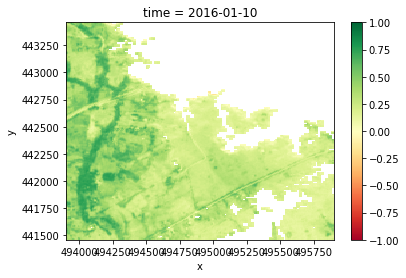

In [25]:
mask = sentinel.mask.sel(time='2016-01-10').isel(x=slice(500,700),y=slice(500,700))
sentinel.isel(x=slice(500,700),y=slice(500,700)).sel(time='2016-01-10').where(mask).plot(cmap='RdYlGn', vmax=1, vmin=-1)

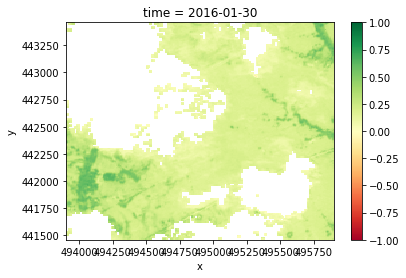

In [20]:
mask = sentinel.mask.sel(time='2016-01-30').isel(x=slice(500,700),y=slice(500,700))
sentinel.isel(x=slice(500,700),y=slice(500,700)).sel(time='2016-01-30').where(mask).plot(cmap='RdYlGn', vmax=1, vmin=-1)

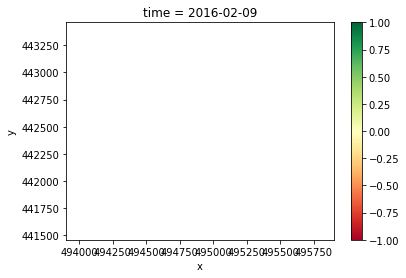

In [26]:
mask = sentinel.mask.sel(time='2016-02-09').isel(x=slice(500,700),y=slice(500,700))
sentinel.isel(x=slice(500,700),y=slice(500,700)).sel(time='2016-02-09').where(mask).plot(cmap='RdYlGn', vmax=1, vmin=-1)

In [22]:
sentinel.time

<xarray.DataArray 'time' (time: 7)>
array(['2015-12-21T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-10T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-30T00:00:00.000000000', '2016-02-09T00:00:00.000000000',
       '2016-02-19T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...

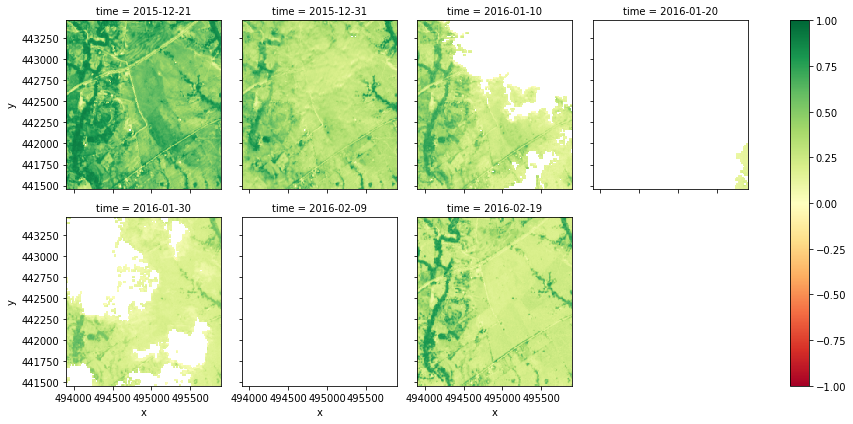

In [28]:
mask = sentinel.mask.isel(x=slice(500,700),y=slice(500,700))
sentinel.isel(x=slice(500,700),y=slice(500,700)).where(mask).plot(col='time', col_wrap=4, cmap='RdYlGn', vmax=1, vmin=-1)

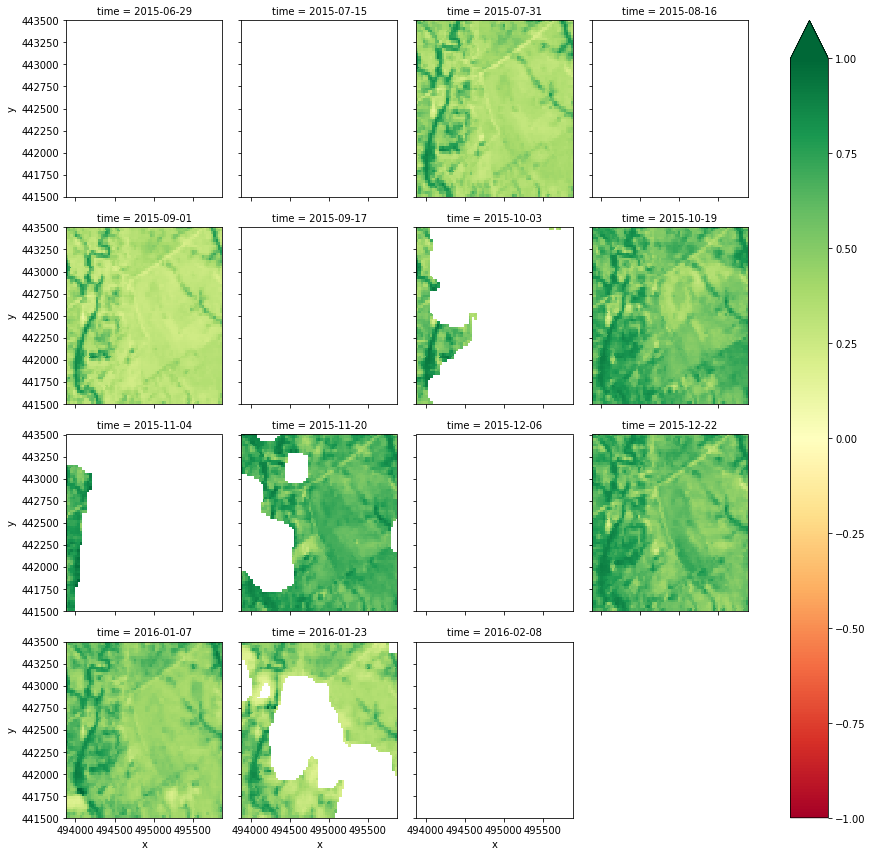

In [29]:
mask = landsat.mask.isel(x=slice(500,700),y=slice(500,700))
landsat.isel(x=slice(500,700),y=slice(500,700)).where(mask).plot(col='time', col_wrap=4, cmap='RdYlGn', vmax=1, vmin=-1)

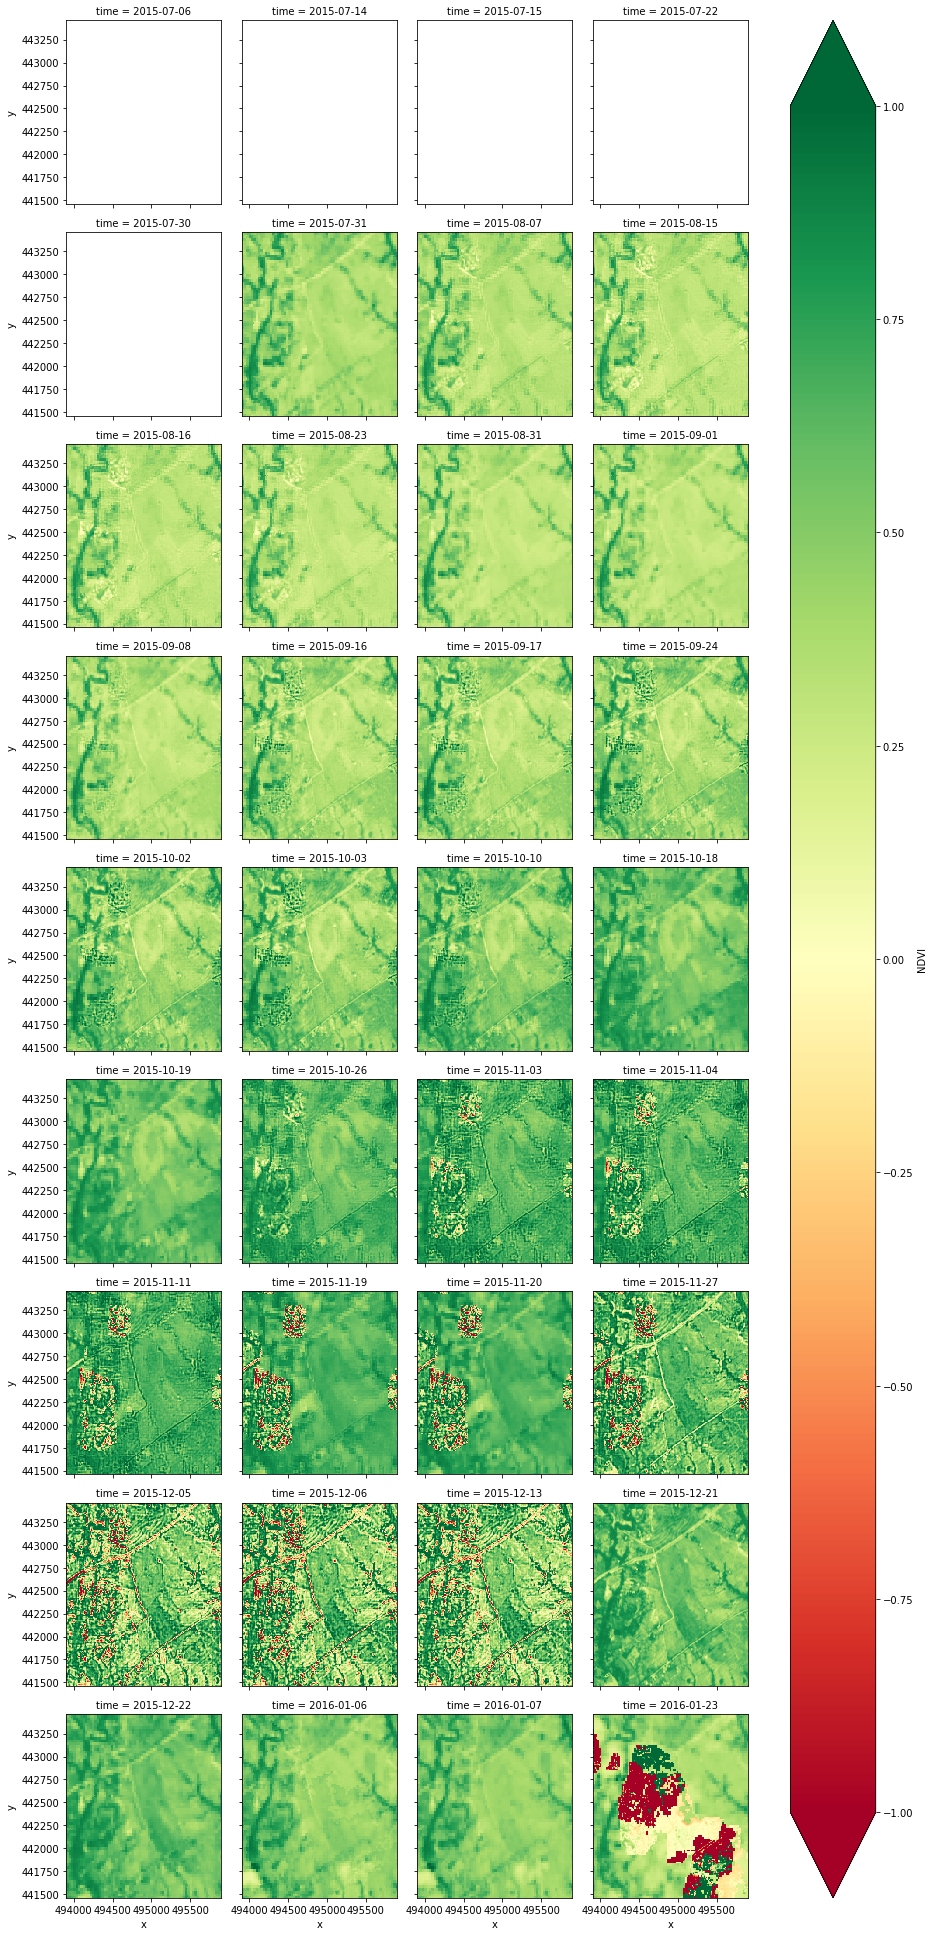

In [14]:
nd.NDVI.isel(x=slice(500,700),y=slice(500,700)).plot(col='time', col_wrap=4, cmap='RdYlGn', vmax=1, vmin=-1)

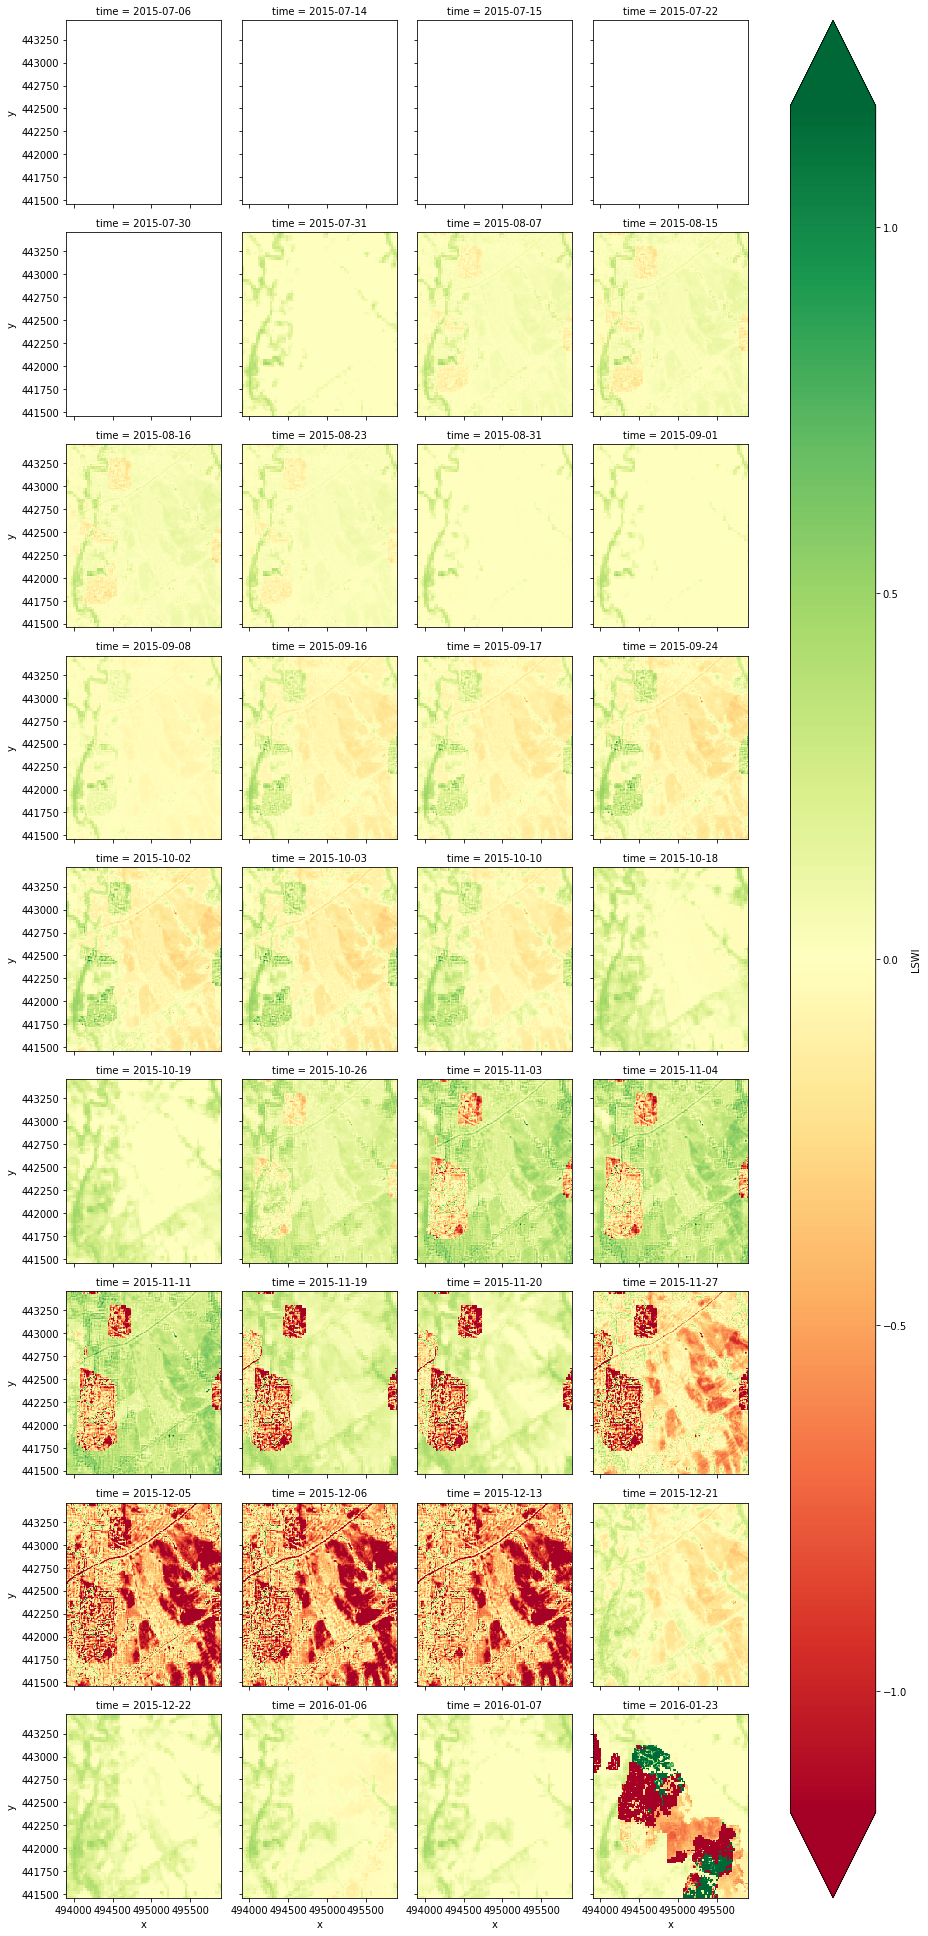

In [12]:
nd.LSWI.isel(x=slice(500,700),y=slice(500,700)).plot(col='time', col_wrap=4, cmap='RdYlGn', robust=True)#vmax=1, vmin=-1)

In [40]:
nd.close()

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 17 14:55:02 2018

@author: ASALAZAR
"""

import os

import geopandas as gpd
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr

from shapely import geometry

def prepare_dataset(inloc, outloc, date_class, shapefile):
    """
    
    Args:
        inloc (str): path of the location of datasets to process
        outloc (str): path of location to write resulting dataframe as parquet
        date_class ([(str, np.datetime64)]): list of tuples with the first
                        element indicating the column name with the class
                        data in the shapefile and the second the corresponding
                        date. e.g ('X20151222', np.datetime64('2015-12-22'))
        shapefile (str): path of location of the shapefile with class data
        
    """
    
    #Read shapefile TO-DO enable to specify crs
    fields_shp = gpd.read_file(shapefile).to_crs({'init': 'epsg:32618'})
    
    #Indicate if used as train or test
    # based on dictionary for each dic[date][polygon_index]:test/train
    ## eg {np.datetime('2015-12-22'):'2WKSD7':'train'} 
    class_dict = assign_polygons_to_class(date_class, fields_shp)
    
    dss = os.listdir(inloc)
    #Open the datasets
    dss = list(map(lambda ds: xr.open_dataset(inloc+ds), dss))
    
    date_dataframes = []
    
    for date in date_class:
        date_dataframes.append(create_date_dataframe(dss,
                                                     fields_shp,
                                                     date[1],
                                                     date[0],
                                                     class_dict[date[1]]))
    
    data = dd.concat(date_dataframes, axis=0, interleave_partitions=True)
    
    #Write results with valid polygon class data outloc
    dd.to_parquet(data[data['vclass']>0], outloc)

def assign_polygons_to_class(passed_list, fields_shp, seed=48):
    """
    passed_list ([(str, np.datetime64)]): list of tuples with the first
                        element indicating the column name with the class
                        data in the shapefile and the second the corresponding
                        date. e.g ('X20151222', np.datetime64('2015-12-22'))
        fields_shp (str): path of location of the shapefile with class data
    """
    
    classes = np.empty(0)
    polygons = np.empty(0).astype(str)
    
    #Get the classes and polygons to be used
    for date in passed_list:
        classes = np.append(classes, fields_shp[date[0]])
        polygons = np.append(polygons, fields_shp['IDLote'])
    
    #Use this to know the date for assigning at the end
    npolygons = fields_shp.shape[0]
    
    #Use method to map the number of polygons for each class and their indices
    seqidx = list_indices(classes)
    
    
    #Randomly shuffle indices in a new dictionary
    unsorted = {}
    
    for k,val in seqidx.items():
        if not np.isnan(k):
            unsorted[k] = np.random.RandomState(seed=seed).permutation(np.array(val)).tolist()
    
    #Split the train and test datasets in around 70% train and 30% test
    train = []
    test = []
    
    for k,val in unsorted.items():
        split_loc = int(round(len(val)*0.7,0))
        train = train + val[:split_loc]
        test = test + val[split_loc:]
        
    # Declare final dictionary    
    final_dict = {}
    for element in passed_list:
        final_dict[element[1]] = {}
    
    # Populate final dictionary using split indices
    for idx in train:
        date = passed_list[idx // npolygons][1]
        final_dict[date][polygons[idx]] = 'train'
    
    for idx in test:
        date = passed_list[idx // npolygons][1]
        final_dict[date][polygons[idx]] = 'test'
        
    return final_dict

def list_indices(seq):
    """
    Make a dictionary of values of a sequence with a list of their indices in the original sequence
    
    Args:
        seq (list): a list of elements
    
    Returns:
        counter (defaultdic): dictionary with elements as keys and indices
                                as values
    """
    from collections import defaultdict
    counter = defaultdict(list)
    for i,item in enumerate(seq):
        counter[item].append(i)
    return counter

def create_date_dataframe(dss, fields_shp, doa, class_col_name, class_use_dict):
    
    #Put intermediate data frames in a list
    field_dataframes = []
    
    #Iterate geo-dataframe
    for idx, shape in fields_shp.iterrows():
        
        # Indicate column of field ID
        IDLote = shape['IDLote']
        # Indicate column of phenology class value
        class_value  = shape[class_col_name]
        # Indicate the geometry column
        polygon = shape['geometry']
        
        if not np.isnan(class_value):
            df = get_field_dataset(dss, polygon, class_value, doa)
            
            df['IDLote'] = IDLote
            
            df['time'] = doa
            
            try:
                df['tt'] = class_use_dict[IDLote]
            except KeyError:
                df['tt'] = 'nd'
                
            field_dataframes.append(df)
    
    #Concatenate dask dataframes for all fields 
    data = dd.concat(field_dataframes, axis=0, interleave_partitions=True)
    
    return data
    

def get_field_dataset(datasets, polygon, class_value, doa):
    """
    Open xarray Datasets and subset data using a polygon.
    
    Args:
        datasets([str]): xr.Dataset objects for the region of the polygons
        polygon (shapely.geometry.polygon.Polygon): field polygon
        class_value (int): field class value
        doa (np.datetime64): date of analysis
    
    Returns:
        df (dask.DataFrame): a dask dataframe of all variables in datasets
    """
    
    #Select to polygon bounds
    bounds = polygon.bounds
    
    #Subset the datasets using polygon bounds
    var_data_list = list(map(lambda ds: ds.sel(x=slice(bounds[0],bounds[2]),
                                               y=slice(bounds[3],bounds[1])),
                             datasets))
    
    # Reshape and rename variables
    var_data_list = list(map(lambda ds: reshape_variables(ds, doa=doa), var_data_list))
    
    # Merge all dataset variables files
    final_ds = xr.merge(var_data_list)
    
    # Assign vegetation class
    assign_class_tag(final_ds, polygon, class_value)
    
    #
    df = final_ds.to_dask_dataframe()
    
    return df

def reshape_variables(dataset, doa, var='all'):
    """
    Reshape and rename dataset variables with names relative to a date of interest
    
    Args:
        dataset(xr.Dataset): dataset with bariables to be reshaped
        doa(np.datetime64): date to be used to calculate names
        var([str] or 'all'): list with string names of variables to be included
                        if not specified all variables in dataset are considered
    
    Returns:
        result(xr.Dataset): all variables renamed to Var_#Days relative to doa
                            a letter 'n' is used to replace negative signs for
                            dates before doa
    """
    
    list_for_ints = []
    
    if var == 'all':
        var = list(dataset.data_vars.keys())
    elif type(var) is not list:
        raise ValueError('The var parameter must be a list')
        
    for variable in var:
        interm = dataset[variable]
        
        relative_time = (pd.to_datetime(interm.time.values) - doa).days.values
        
        interm['time'] = list(map(lambda x: variable+'_'+str(x).replace('-','n'),
              relative_time))
        
        list_for_ints.append(interm.to_dataset(dim='time'))
    
    result = xr.merge(list_for_ints)
    
    return result

def assign_class_tag(dataset, polygon, class_value):
    """
    Assign new dataset variable in points intersected by a polygon
    to the specified class_value, otherwihise assigns zero.
    
    Args:
        dataset(xr.Dataset): dataset to be modified
        polygon (shapely.geometry.polygon.Polygon): field polygon
        class_value (uint8): value to be assigned to polygon
    
    """
    
    dataset['vclass'] = (['y','x'],
                         np.zeros((dataset.y.shape[0],
                                   dataset.x.shape[0])).astype(np.uint8))
    
    for x in dataset.x.values:
        for y in dataset.y.values:
            if geometry.point.Point(x,y).within(polygon):
                dataset['vclass'].loc[dict(y=y,x=x)] = class_value

In [25]:
shapefile = '/home/azalazar/data/saldana2.shp'
inloc = os.environ['WIN_SVR_DATA']+'Saldana2/features/'
outloc = os.environ['WIN_SVR_DATA']+'Saldana2/featdf2/'
date_class = [('X20151222', np.datetime64('2015-12-22')),
              ('X20160107', np.datetime64('2016-01-07')),
              ('X20151206', np.datetime64('2015-12-06'))]

In [22]:
#Specify the dates to be included in the dataset (requires knowledge of the geo-dataframe structure)
prepare_dataset(inloc, outloc, date_class, shapefile)

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:295: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  for df in dfs3], join=join).any()
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  out = pd.concat(dfs3, join=join)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:295: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  out = pd.concat(dfs3, join=join)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  out = pd.concat(dfs3, join=join)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/dask/dataframe/methods.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by d

In [165]:
import geopandas as gpd
from shapely import geometry
import dask.dataframe as dd
import xarray as xr

In [201]:
#Get training classes

dss = [os.environ['WIN_SVR_DATA']+'Saldana2/features/NDVI.nc', os.environ['WIN_SVR_DATA']+'Saldana2/features/VV.nc']
data_loc = os.environ['WIN_SVR_DATA']+'Saldana2/parquet/'

In [192]:
#Put intermediate data frames in a list
field_dataframes = []

#Iterate geo-dataframe
for idx, shape in fields_shp.iterrows():
    
    # Indicate column of field ID
    IDLote = shape['IDLote']
    # Indicate column of phenology class value
    class_value  = shape['X20151222']
    # Indicate the geometry column
    polygon = shape['geometry']
    
    if not np.isnan(class_value):
        df = get_field_dataset(dss, polygon, class_value)
        
        df['IDLote'] = IDLote
        
        field_dataframes.append(df)

#Concatenate dask dataframes for all fields 
data = dd.concat(field_dataframes, axis=0, interleave_partitions=True)

#Write results with valid polygon class data
dd.to_parquet(data[data['vclass']>0], data_loc)

In [210]:
loaded = data#data[data['IDLote']=='21C914']
loaded = loaded.compute()

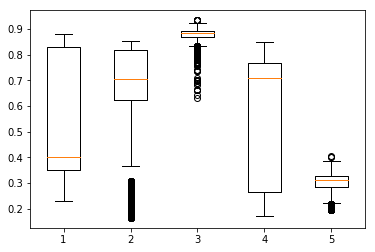

In [216]:
from matplotlib import pyplot as plt

def show_boxplot(variable='NDVI_0'):
    
    data = [loaded[variable][loaded['vclass']==1],loaded[variable][loaded['vclass']==2],
            loaded[variable][loaded['vclass']==3],loaded[variable][loaded['vclass']==4],
            loaded[variable][loaded['vclass']==5]]
    
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)

    ax.boxplot(data)
    None
    
show_boxplot()

In [266]:
variable1 = 'NDVI_0'
variable2 = 'NDVI_n96'

xdata = [loaded[variable1][loaded['vclass']==1],#loaded[variable2][loaded['vclass']==1]),
        loaded[variable1][loaded['vclass']==2],#loaded[variable2][loaded['vclass']==2]),
        loaded[variable1][loaded['vclass']==3],#loaded[variable2][loaded['vclass']==3]),
        loaded[variable1][loaded['vclass']==4],#loaded[variable2][loaded['vclass']==4]),
        loaded[variable1][loaded['vclass']==5]]#,loaded[variable2][loaded['vclass']==5])]

ydata = [loaded[variable2][loaded['vclass']==1],#loaded[variable2][loaded['vclass']==1]),
        loaded[variable2][loaded['vclass']==2],#loaded[variable2][loaded['vclass']==2]),
        loaded[variable2][loaded['vclass']==3],#loaded[variable2][loaded['vclass']==3]),
        loaded[variable2][loaded['vclass']==4],#loaded[variable2][loaded['vclass']==4]),
        loaded[variable2][loaded['vclass']==5]]#,loaded[variable2][loaded['vclass']==5])]


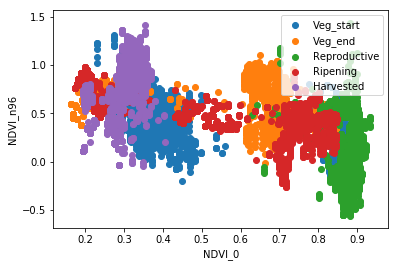

In [267]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

plt.xlabel(variable1)
plt.ylabel(variable2)

ax.scatter(xdata[0], ydata[0], c='tab:blue', label='Veg_start')
ax.scatter(xdata[1], ydata[1], c='tab:orange', label='Veg_end')
ax.scatter(xdata[2], ydata[2], c='tab:green', label='Reproductive')
ax.scatter(xdata[3], ydata[3], c='tab:red', label='Ripening')
ax.scatter(xdata[4], ydata[4], c='tab:purple', label='Harvested')

ax.legend()

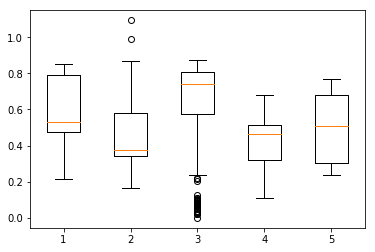

In [222]:
show_boxplot('NDVI_16')

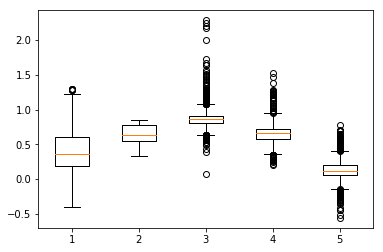

In [218]:
show_boxplot('NDVI_n16')

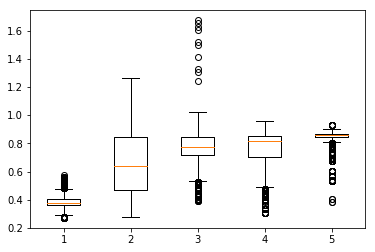

In [219]:
show_boxplot('NDVI_n32')

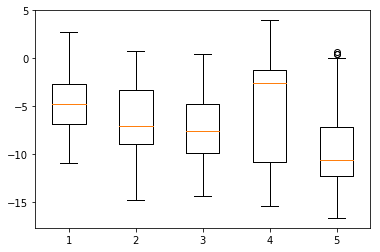

In [221]:
show_boxplot('VV_n32')

In [187]:
loaded.set_index(['x', 'y'], verify_integrity=True, inplace=True)
back_to_xr = xr.Dataset.from_dataframe(loaded)

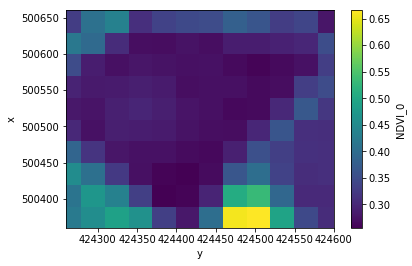

In [191]:
back_to_xr.NDVI_0.plot()

In [196]:

def get_field_dataset(datasets, polygon, class_value, doa):
    """
    Open xarray Datasets and subset data using a polygon.
    
    Args:
        datasets([str]): list of file paths to xr.Dataset (.nc) files
        polygon (shapely.geometry.polygon.Polygon): field polygon
        class_value (int): field class value
        doa (np.datetime64): date of analysis
    
    Returns:
        df (dask.DataFrame): a dask dataframe of all variables in datasets
    """
    
    #Open the datasets
    var_data_list = list(map(lambda ds: xr.open_dataset(ds), datasets))
    
    #Select to polygon bounds
    bounds = polygon.bounds
    
    #Subset the datasets using polygon bounds
    var_data_list = list(map(lambda ds: ds.sel(x=slice(bounds[0],bounds[2]),
                                               y=slice(bounds[3],bounds[1])),
                             var_data_list))
    
    # Reshape and rename variables
    var_data_list = list(map(lambda ds: reshape_variables(ds, doa=doa), var_data_list))
    
    # Merge all dataset variables files
    final_ds = xr.merge(var_data_list)
    
    # Assign vegetation class
    assign_class_tag(final_ds, polygon, class_value)
    
    #
    df = final_ds.to_dask_dataframe()
    
    return df

def reshape_variables(dataset, doa, var='all'):
    """
    Reshape and rename dataset variables with names relative to a date of interest
    
    Args:
        dataset(xr.Dataset):
        doa(np.datetime64): date to be used to calculate names
        var([str] or ´all´): list with string names of variables to be included
                        if not specified all variables in dataset are considered
    
    Returns:
        result(xr.Dataset): all variables renamed to Var_#Days relative to doa
                            a letter ´n´ is used to replace negative signs for
                            dates before doa
    """
    
    list_for_ints = []
    
    if var == 'all':
        var = list(dataset.data_vars.keys())
    elif type(var) is not list:
        raise ValueError('The var parameter must be a list')
        
    for variable in var:
        interm = dataset[variable]
        
        relative_time = (pd.to_datetime(interm.time.values) - time_base).days.values
        
        interm['time'] = list(map(lambda x: variable+'_'+str(x).replace('-','n'), relative_time))
        
        list_for_ints.append(interm.to_dataset(dim='time'))
    
    result = xr.merge(list_for_ints)
    
    return result

def assign_class_tag(dataset, polygon, class_value):
    """
    Assign new dataset variable in points intersected by a polygon
    to the specified class_value, otherwihise assigns zero.
    
    Args:
        dataset(xr.Dataset): dataset to be modified
        polygon (shapely.geometry.polygon.Polygon): field polygon
        class_value (uint8): value to be assigned to polygon
    
    """
    
    dataset['vclass'] = (['y','x'],
                         np.zeros((dataset.y.shape[0],
                                   dataset.x.shape[0])).astype(np.uint8))
    
    for x in dataset.x.values:
        for y in dataset.y.values:
            if geometry.point.Point(x,y).within(polygon):
                dataset['vclass'].loc[dict(y=y,x=x)] = class_value

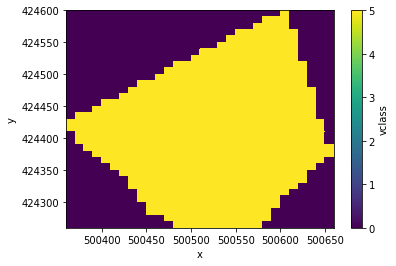

In [122]:
a.vclass.plot()

In [123]:
type(polygon)

shapely.geometry.polygon.Polygon

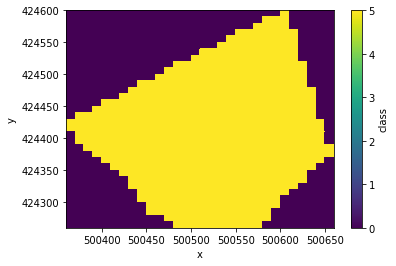

In [72]:
ds['class'].plot()

In [73]:
df = ds.to_dask_dataframe()
df

Dask DataFrame Structure:
                     x        y  NDVI_16   NDVI_0 NDVI_n16 NDVI_n32 NDVI_n48 NDVI_n64 NDVI_n80 NDVI_n96    VV_16     VV_0   VV_n16   VV_n32   VV_n48   VV_n64   VV_n80   VV_n96  VV_n112  VV_n128  VV_n144  VV_n160  VV_n176  VV_n192    class
npartitions=1                                                                                                                                                                                                                                 
0              float64  float64  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float64
1019               ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
Dask Name: concat-indexed, 151 tasks

In [53]:
df['class'] = fields_shp['X20151222'][0]

In [54]:
df

Dask DataFrame Structure:
                     x        y  NDVI_16   NDVI_0 NDVI_n16 NDVI_n32 NDVI_n48 NDVI_n64 NDVI_n80 NDVI_n96    VV_16     VV_0   VV_n16   VV_n32   VV_n48   VV_n64   VV_n80   VV_n96  VV_n112  VV_n128  VV_n144  VV_n160  VV_n176  VV_n192    class
npartitions=1                                                                                                                                                                                                                                 
0              float64  float64  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float32  float64
1019               ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
Dask Name: assign, 146 tasks

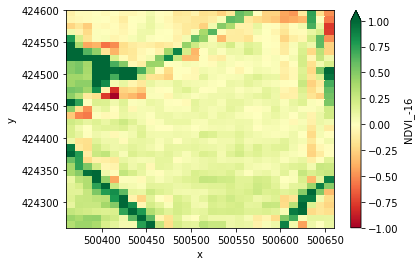

In [20]:
test['NDVI_-16'].plot(cmap='RdYlGn', vmax=1, vmin=-1)

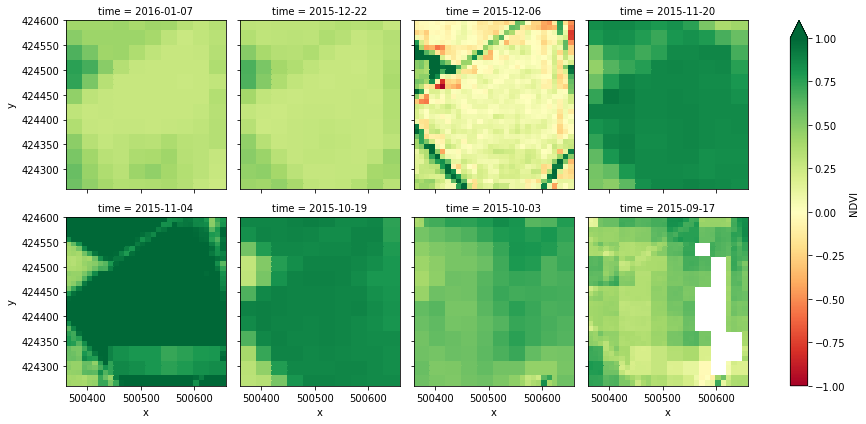

In [58]:
poly_data.NDVI.plot(col='time', col_wrap=4, cmap='RdYlGn', vmax=1, vmin=-1)

## Create train test datasets
Make the division considering a balanced number of polygons for each class

In [270]:
passed_list = [('X20160107', np.datetime64('2016-01-07')), ('X20151222', np.datetime64('2015-12-22'))]

In [271]:
passed_list

[('X20160107', numpy.datetime64('2016-01-07')),
 ('X20151222', numpy.datetime64('2015-12-22'))]

In [288]:
classes = np.empty(0)
polygons = np.empty(0).astype(str)

for date in passed_list:
    classes = np.append(classes, fields_shp[date[0]])
    polygons = np.append(polygons, fields_shp['IDLote'])

In [296]:
#Use this to know the polygon id
npolygons = fields_shp.shape[0]

In [357]:
seqidx = list_indices(classes)

In [358]:

#Randomly shuffle indices in a new dictionary
unsorted = {}

for k,val in seqidx.items():
    if not np.isnan(k):
        unsorted[k] = np.random.RandomState(seed=33).permutation(np.array(val)).tolist()

#Split the train and test datasets in around 70% train and 30% test
train = []
test = []

for k,val in unsorted.items():
    
    train = train + val[:int(round(len(val)*0.7,0))]
    test = test + val[int(round(len(val)*0.7,0)):]

In [361]:
print(train)

[1, 32, 21, 15, 17, 5, 29, 10, 20, 33, 34, 18, 23, 38, 36, 11, 25, 37, 6, 30, 7, 31, 27]


In [362]:
print(test)

[28, 22, 16, 2, 3, 4, 35, 24, 26]


In [367]:
##Use the indices to get the original data
train_classes = list(map(lambda x: classes[x], train))
print(train_classes)
test_classes = list(map(lambda x: classes[x], test))
print(test_classes)

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0]
[4.0, 4.0, 4.0, 5.0, 1.0, 3.0, 3.0, 3.0, 2.0]


In [368]:
##Use the indices to get the original data
train_poly = list(map(lambda x: polygons[x], train))
print(train_poly)

test_poly = list(map(lambda x: polygons[x], test))
print(test_poly)

['21C908', '52B404A', '21C908', '62D835A', '42A304', '21C919', '31E723', '42C018', '21C914', '52B002', '52B902B', '52D618', '21D823', '52D618', '52E309', '42A028A', '21C919', '42A304', '11B011A', '42C018', '31D097', '42A028A', '31D097']
['31D091', '21D813A', '52E309', '21D813A', '21D823', '21C918', '62D835A', '21C918', '11B011A']


In [373]:
final_dict = {}

for element in passed_list:
    final_dict[element[1]] = {}

for idx in train:
    date = passed_list[idx // npolygons][1]
    final_dict[date][polygons[idx]] = 'train'

for idx in test:
    date = passed_list[idx // npolygons][1]
    final_dict[date][polygons[idx]] = 'test'

In [374]:
final_dict

{numpy.datetime64('2016-01-07'): {'21C908': 'train',
  '62D835A': 'train',
  '42A304': 'train',
  '21C919': 'train',
  '42C018': 'train',
  '52D618': 'train',
  '42A028A': 'train',
  '11B011A': 'train',
  '31D097': 'train',
  '52E309': 'test',
  '21D813A': 'test',
  '21D823': 'test',
  '21C918': 'test'},
 numpy.datetime64('2015-12-22'): {'52B404A': 'train',
  '21C908': 'train',
  '31E723': 'train',
  '21C914': 'train',
  '52B002': 'train',
  '52B902B': 'train',
  '21D823': 'train',
  '52D618': 'train',
  '52E309': 'train',
  '21C919': 'train',
  '42A304': 'train',
  '42C018': 'train',
  '42A028A': 'train',
  '31D097': 'train',
  '31D091': 'test',
  '21D813A': 'test',
  '62D835A': 'test',
  '21C918': 'test',
  '11B011A': 'test'}}

In [336]:
[0,1,2,3,4,5][:int(round(len(unsorted[2.0])*0.7,0))]

[0, 1]

In [300]:
seqidx[1.0]

[3, 18, 23, 38]

In [301]:
seqidx[2.0]

[26, 27, 31]

In [302]:
seqidx[3.0]

[4, 6, 7, 11, 24, 25, 30, 35, 36, 37]

In [303]:
seqidx[4.0]

[1, 5, 10, 15, 16, 17, 21, 22, 28, 29, 32]

In [304]:
seqidx[5.0]

[2, 20, 33, 34]

In [285]:
def list_indices(seq):
    """
    Make a dictionary of values of a sequence with a list of their indices in the original sequence
    
    Args:
        seq (list): a list of elements
    
    Returns:
        counter (defaultdic): dictionary with elements as keys and indices
                                as values
    """
    from collections import defaultdict
    counter = defaultdict(list)
    for i,item in enumerate(seq):
        counter[item].append(i)
    return counter

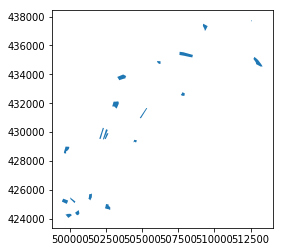

In [22]:
fields_shp.plot()

In [10]:
type(fields_shp)

geopandas.geodataframe.GeoDataFrame

In [9]:
fields_shp.bounds

minx           miny           maxx           maxy
0   500358.069479  424256.080949  500658.798720  424598.674545
1   499698.778805  424063.892322  500138.306303  424346.950204
2   502423.206266  424617.514286  502791.230084  425024.857749
3   501270.757870  425279.688198  501525.212792  425746.572469
4   500010.022993  425089.582169  500380.147871  425478.129105
5   499451.681263  425038.402101  499878.586728  425395.616249
6   499582.081215  428523.786077  499956.398708  429000.052676
7   502285.345325  429489.923321  502616.531867  430204.319578
8   502031.946772  429530.651314  502354.721320  430304.578970
9   504392.447467  429291.553777  504634.273017  429469.111011
10  504831.864651  430958.489655  505348.076786  431674.980353
11  502928.757378  431628.932154  503378.757466  432128.163725
12  507685.303199  432506.514156  507952.355352  432763.426954
13  506032.339169  434724.671506  506272.067243  434916.827392
14  507577.836962  435169.757055  508509.357731  435558.187563
15  512535.820130  437662.070843  512596.793866  437742.482308
16  509201.884144  437026.331326  509533.063159  437500.452425
17  503275.522051  433590.978668  503893.739560  433987.857187
18  512700.059986  434538.069127  513337.272335  435206.411484
19  502406.565850  429510.128652  502666.498587  429927.797879